# Cookie Cats (Mobile Game) A/B Testing

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [23]:
#Load Data from CSV file
df = pd.read_csv("cookie_cats.csv")

#Display df to review data
print(df.head())

   userid  version  sum_gamerounds  retention_1  retention_7
0     116  gate_30               3        False        False
1     337  gate_30              38         True        False
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True


In this analysis, players who played the version with the gate at level 40 are designated as the experimental group, while those who played the version with the gate at level 30 form the control group. The distribution indicates that both groups have approximately the same number of players.

In [24]:
#Calculating the number of samples in each group
group_frequency = df.groupby("version").count()

print(group_frequency)

         userid  sum_gamerounds  retention_1  retention_7
version                                                  
gate_30   44700           44700        44700        44700
gate_40   45489           45489        45489        45489


In [25]:
#Defining the Confidence Level and Practical Significance.

alpha = 0.05
print(f"The significance level is: {alpha}")

delta = 0.1
print(f"The minimum detectable effect is: {delta}")

The significance level is: 0.05
The minimum detectable effect is: 0.1


In [26]:
df.describe()

,userid,sum_gamerounds
count,9.018900e+04,90189.000000
mean,4.998412e+06,51.872457
std,2.883286e+06,195.050858
min,1.160000e+02,0.000000
25%,2.512230e+06,5.000000
50%,4.995815e+06,16.000000
75%,7.496452e+06,51.000000
max,9.999861e+06,49854.000000


# Difference in the Mean Number of Gamerounds

The first analysis explores whether raising the progression requirements in the game affects the total number of rounds played.

#### Null Hypothesis: The mean number of rounds played by both experimental and control groups is the same.

#### Alternative Hypothesis: The mean number of game rounds played by the two groups differs significantly.

## Calculating the mean number of gamerounds per group.

In [27]:
groupmean_gamerounds = df["sum_gamerounds"].mean()
con_gate30_mean_gamerounds =df.groupby("version")["sum_gamerounds"].mean().loc["gate_30"]
exp_gate40_mean_gamerounds =df.groupby("version")["sum_gamerounds"].mean().loc["gate_40"]

print(f"Gamerounds Groupmean: {groupmean_gamerounds.round(2)}")
print(f"Gate 30 Gamerounds mean: {con_gate30_mean_gamerounds.round(2)}")
print(f"Gate 40 Gamerounds mean: {exp_gate40_mean_gamerounds.round(2)}")

Gamerounds Groupmean: 51.87
Gate 30 Gamerounds mean: 52.46
Gate 40 Gamerounds mean: 51.3


The group means indicate that the average number of game rounds is lower for the experimental group compared to the control group. However, further statistical testing is required to determine whether this difference is statistically significant.

## Distribution of Sum game rounds

The distributions of the sum of game rounds for both groups are observed to be right-skewed. Additionally, since the number of game rounds cannot be negative, we will apply a log transformation to the data to normalize the distribution.

In [28]:
control_data = df[df['version'] == 'gate_30']['sum_gamerounds']
experimental_data = df[df['version'] == 'gate_40']['sum_gamerounds']

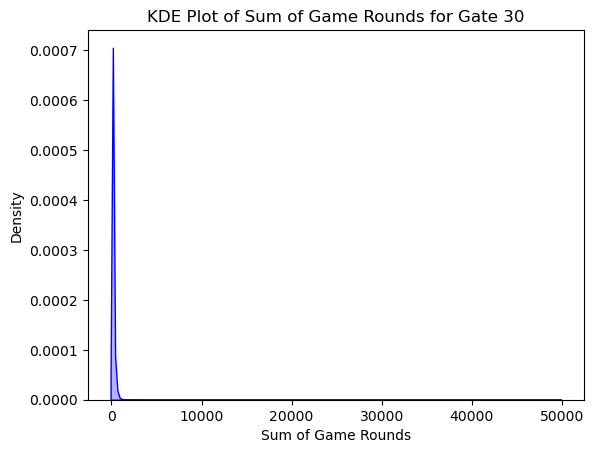

In [29]:
# KDE Plot for Gate 30
sns.kdeplot(control_data, color='blue', fill=True, alpha=0.3)

plt.xlabel('Sum of Game Rounds')
plt.ylabel('Density')
plt.title('KDE Plot of Sum of Game Rounds for Gate 30')
plt.show()

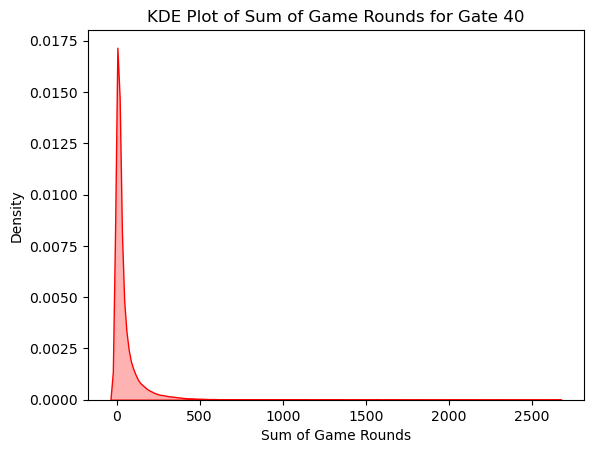

In [30]:
# KDE Plot for Gate 40
sns.kdeplot(experimental_data, color='red', fill=True, alpha=0.3)

plt.xlabel('Sum of Game Rounds')
plt.ylabel('Density')
plt.title('KDE Plot of Sum of Game Rounds for Gate 40')
plt.show()

In [31]:
# Log-transform the data
log_experimental = np.log1p(experimental_data)
log_control = np.log1p(control_data)

## Levene's Test for equal variances

We examine if both groups have equal variance.

#### Null Hypothesis:  The variances of the groups are equal.
#### Alternative Hypothesis: The variances of the groups are not equal.

In [33]:
from scipy.stats import levene

stat, p_value = levene(log_control, log_experimental)

print(f"Levene's Test statistics: {stat}, p-value: {p_value}")

Levene's Test statistics: 4.0292100910924775, p-value: 0.04472185218646192


We conclude that the variances between the groups are not equal. Hence the assumption of equal variances may not hold for subsequent tests.

## Calculating the Standard Error

In [34]:
mean_exp = np.mean(log_experimental)
mean_con = np.mean(log_control)

variance_con = np.var(log_control, ddof=1)
variance_exp = np.var(log_experimental, ddof=1)

n_con = len(df[df["version"] == 'gate_30'])
n_exp = len(df[df["version"] == 'gate_40'])

SE = np.sqrt(variance_con/n_con + variance_exp/n_exp)

print(f"SE: {SE}")

SE: 0.01001439271917973


## Calculating Test Statistics

In [38]:
from scipy.stats import norm

#Creating Z-statistics Function
def calculate_z_stat(point_estimate_1, point_estimate_2, standard_error, alpha):
    Test_stat = (point_estimate_1 - point_estimate_2)/standard_error
    
    Z_crit = norm.ppf(1-alpha/2)
    return Test_stat, Z_crit 

# Calculating the test statistics of Z-test
Test_stat, Z_crit = calculate_z_stat(mean_exp, mean_con, SE, alpha)
print(f"Test statistics for 2-sample Z-test is: {Test_stat}")
print(f"Z-critical Value from standard normal distribution: {Z_crit.round(2)}")

Test statistics for 2-sample Z-test is: -1.814245669299862
Z-critical Value from standard normal distribution: 1.96


## Calculating p_values of the 2 sample Z-test

In [39]:
#Calculating p value
p_value = 2*norm.sf(abs(Test_stat))

print(f"P-Value for right-tailed test: {p_value}")

P-Value for right-tailed test: 0.06963991196420964


Since the p-value is greater than 0.05, we do not have sufficient evidence to reject the null hypothesis. Therefore, we conclude that there is no significant difference in the mean number of game rounds played between the two groups. This suggests that the changes in game requirements do not significantly impact the total number of game rounds played by players.

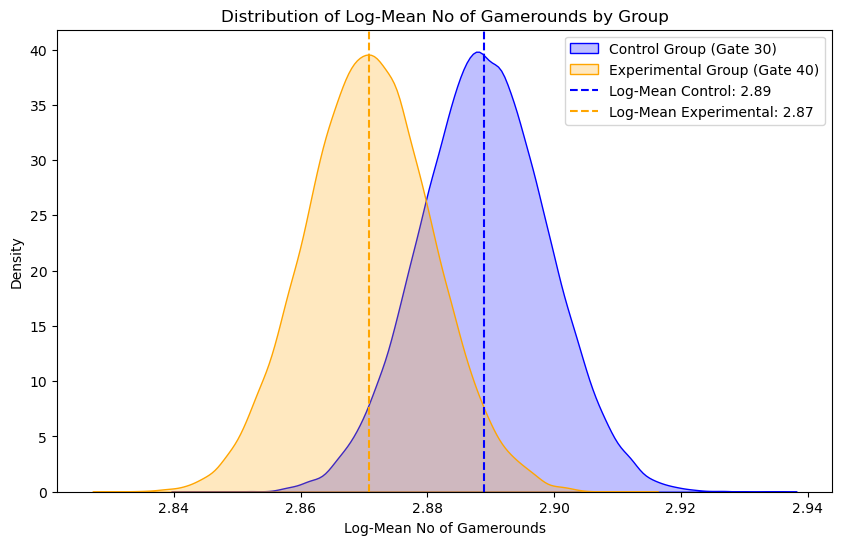

In [40]:
std_con = np.sqrt(variance_con)
std_exp = np.sqrt(variance_exp)

control_data = np.random.normal(mean_con, SE, n_con)
experiment_data = np.random.normal(mean_exp, SE, n_exp)

# Plotting the distributions
plt.figure(figsize=(10, 6))

# Control group distribution
sns.kdeplot(control_data, fill=True, color="blue", label="Control Group (Gate 30)")

# Experimental group distribution
sns.kdeplot(experiment_data, fill=True, color="orange", label="Experimental Group (Gate 40)")

# Plot the mean of both distributions
plt.axvline(mean_con, color="blue", linestyle="--", label=f"Log-Mean Control: {mean_con.round(2)}")
plt.axvline(mean_exp, color="orange", linestyle="--", label=f"Log-Mean Experimental: {mean_exp.round(2)}")

# Adding titles and labels
plt.title('Distribution of Log-Mean No of Gamerounds by Group')
plt.xlabel('Log-Mean No of Gamerounds')
plt.ylabel('Density')
plt.legend()

# Display the plot
plt.show()

# Difference in the Proportion of player that come back and play 1 day after installing. 

For the second analysis, we explore whether raising the progression requirements in the game impact the proportion of players who come back to play the game 1 day after installing.

#### Null Hypothesis: The proportion of players that return to play 1 day after installing is the same for both groups.
#### Alternative Hypothesis: The proportion of players that return to play 1 day after installing differs significantly.


In [47]:
#Converting boolean to int
df[["retention_1", "retention_7"]] = df[["retention_1", "retention_7"]].astype(int)

print(df)

        userid  version  sum_gamerounds  retention_1  retention_7
0          116  gate_30               3            0            0
1          337  gate_30              38            1            0
2          377  gate_40             165            1            0
3          483  gate_40               1            0            0
4          488  gate_40             179            1            1
...        ...      ...             ...          ...          ...
90184  9999441  gate_40              97            1            0
90185  9999479  gate_40              30            0            0
90186  9999710  gate_30              28            1            0
90187  9999768  gate_40              51            1            0
90188  9999861  gate_40              16            0            0

[90189 rows x 5 columns]


In [43]:
#Calculating the total number of players that come back and play 1 day after installing for each group.

con_gate30_proportion_retention_1 =df.groupby("version")["retention_1"].sum().loc["gate_30"]
exp_gate40_proportion_retention_1 =df.groupby("version")["retention_1"].sum().loc["gate_40"]

con_proportion_retention_1 = con_gate30_proportion_retention_1 / n_con
exp_proportion_retention_1 = exp_gate40_proportion_retention_1/ n_exp

print(f"Proportion of Control Group that return after 1 day: {con_proportion_retention_1.round(2)}")
print(f"Proportion of Experimental Group that return after 1 day: {exp_proportion_retention_1.round(2)}")

Proportion of Control Group that return after 1 day: 0.45
Proportion of Experimental Group that return after 1 day: 0.44


The calculation of the proportion of both groups reveals that the experiemental group has a lower proportion. However, further statistical testing is required to determine whether this difference is statistically significant.

## Calculating Pooled Variance

In [44]:
def pooled_variance_proportion(proportion_1, proportion_2, sample_size_1, sample_size_2):
    pooled_variance_proportion = (((proportion_1 * (1 - proportion_1)) / sample_size_1)) + (((proportion_2 * (1 - proportion_2)) / sample_size_2))
    return pooled_variance_proportion

pooled_variance_retention_1 = pooled_variance_proportion(con_proportion_retention_1, exp_proportion_retention_1, n_con, n_exp)

print(f"Pooled Variance (proportion): {pooled_variance_retention_1}")

Pooled Variance (proportion): 1.09553869072186e-05


## Calculating Standard Error and Test Statistics

In [45]:
# Calculating the standard error of the test
SE_retention_1 = np.sqrt(pooled_variance_retention_1)
print(f"Standard Error is: {SE_retention_1}")

# Calculating the test statistics of 2 sample Z-test
Test_stat_retention_1, Z_crit_retention_1 = calculate_z_stat(con_proportion_retention_1, exp_proportion_retention_1, SE_retention_1, alpha) 
print(f"Test statistics for 2 samples Z-test: {Test_stat_retention_1.round(2)}")

Standard Error is: 0.003309892280304391
Test statistics for 2 samples Z-test: 1.78


## Calculating p_values of the 2 sample Z-test

In [46]:
#Calculate p value
p_value_retention_1 = 2 * norm.sf(abs(Test_stat_retention_1))

print(f"P-Value: {p_value_retention_1}")

P-Value: 0.07440786052349997


Since the p-value is greater than 0.05, we do not have sufficient evidence to reject the null hypothesis. Therefore, we conclude that there is no significant difference in the proportion of return players 1 day after installing the game between the two groups.

## Visualising distribution of both groups

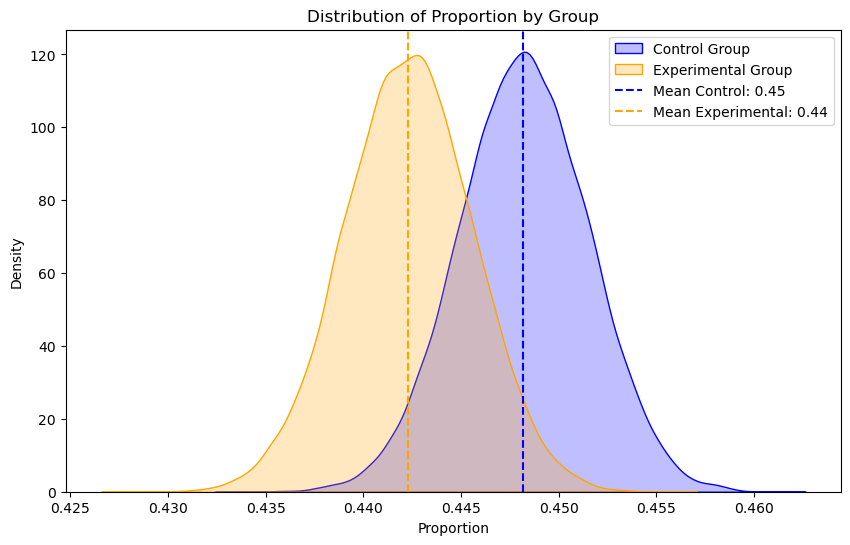

In [48]:
control_data_retention_1 = np.random.normal(con_proportion_retention_1, SE_retention_1, n_con)
experiment_data_retention_1 = np.random.normal(exp_proportion_retention_1, SE_retention_1, n_exp)

#create function to plot the distribution of both control and experiment group.
def plot_distribution_of_2sample(control_data, experiment_data, point_estimate_1, point_estimate_2):
    plt.figure(figsize=(10, 6))
    
    sns.kdeplot(control_data, fill=True, color="blue", label="Control Group")
    sns.kdeplot(experiment_data, fill=True, color="orange", label="Experimental Group")

    plt.axvline(point_estimate_1, color="blue", linestyle="--", label=f"Mean Control: {point_estimate_1.round(2)}")
    plt.axvline(point_estimate_2, color="orange", linestyle="--", label=f"Mean Experimental: {point_estimate_2.round(2)}")
    plt.title('Distribution of Proportion by Group')
    plt.xlabel('Proportion')
    plt.ylabel('Density')
    plt.legend()
    plt.show()
    
plot_distribution_of_2sample(control_data_retention_1, experiment_data_retention_1, con_proportion_retention_1, exp_proportion_retention_1)

The plot shows that the distributions of both groups are very similar, suggesting the possibility that both groups may come from the same underlying population.

# Difference in the Proportion of player that come back and play 7 days after installing. 

For the second analysis, we explore whether raising the progression requirements in the game impact the proportion of players who come back to play the game 7 day after installing.

#### Null Hypothesis: The proportion of players that return to play 7 day after installing is the same for both groups.
#### Alternative Hypothesis: The proportion of players that return to play 7 day after installing differs significantly.

In [49]:
#Calculating the total number of players that come back and play 1 day after installing for each group.

con_gate30_proportion_retention_7 =df.groupby("version")["retention_7"].sum().loc["gate_30"]
exp_gate40_proportion_retention_7 =df.groupby("version")["retention_7"].sum().loc["gate_40"]

con_proportion_retention_7 = con_gate30_proportion_retention_7 / n_con
exp_proportion_retention_7 = exp_gate40_proportion_retention_7/ n_exp

print(f"Proportion of Control Group that return after 7 day: {con_proportion_retention_7.round(2)}")
print(f"Proportion of Experimental Group that return after 7 day: {exp_proportion_retention_7.round(2)}")

Proportion of Control Group that return after 7 day: 0.19
Proportion of Experimental Group that return after 7 day: 0.18


Once again the calculation of the proportion of both groups reveals that the experiemental group has a lower proportion. However, further statistical testing is required to determine whether this difference is statistically significant.

## Calculating pooled variance

In [50]:
pooled_variance_retention_7 = pooled_variance_proportion(con_proportion_retention_7, exp_proportion_retention_7, n_con, n_exp)

print(f"Pooled Variance (proportion): {pooled_variance_retention_7}")

Pooled Variance (proportion): 6.718536619192559e-06


## Calculating Standard Error and Test Statistics

In [51]:
# Calculating the standard error of the test
SE_retention_7 = np.sqrt(pooled_variance_retention_7)
print(f"Standard Error is: {SE_retention_7}")

# Calculating the test statistics of 2 sample Z-test
Test_stat_retention_7, Z_crit_retention_7 = calculate_z_stat(con_proportion_retention_7, exp_proportion_retention_7, SE_retention_7, alpha) 
print(f"Test-statistics for 2 samples Z-test: {Test_stat_retention_7.round(2)}")

Standard Error is: 0.0025920140082940444
Test-statistics for 2 samples Z-test: 3.16


## Calculating p_values of the 2 samples Z-test

In [52]:
#Calculate p value
p_value_retention_7 = 2 * norm.sf(abs(Test_stat_retention_7))

print(f"P-Value: {p_value_retention_7}")

P-Value: 0.0015558255737072547


Since 0.00 < 0.05, we conclude that the proportion of players that return to play 7 days after installing the game differs significantly.

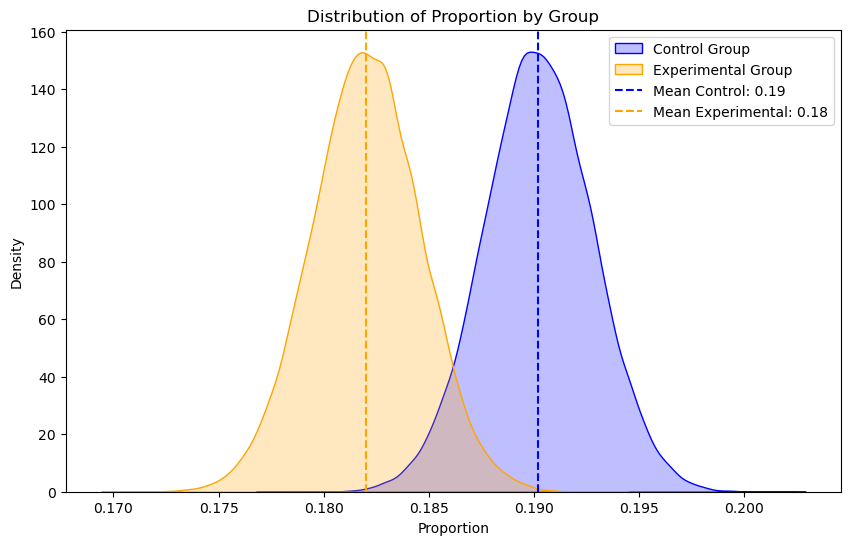

In [167]:
control_data_retention_7 = np.random.normal(con_proportion_retention_7, SE_retention_7, n_con)
experiment_data_retention_7 = np.random.normal(exp_proportion_retention_7, SE_retention_7, n_exp)

plot_distribution_of_2sample(control_data_retention_7, experiment_data_retention_7, con_proportion_retention_7, exp_proportion_retention_7)

## Confidence Interval for group that played on game version that requires 40 levels to progress.

In [53]:
# Experimental group confidence interval
CI_lower_exp = exp_proportion_retention_7 - Z_crit * SE_retention_7
CI_upper_exp = exp_proportion_retention_7 + Z_crit * SE_retention_7
print(f"95% Confidence Interval for Experimental Group: [{CI_lower_exp.round(4)}, {CI_upper_exp.round(4)}]")

95% Confidence Interval for Experimental Group: [0.1769, 0.1871]


With a 95% confidence level, the experimental group has a retention rate between 17.69% and 18.71%, which is significantly lower than the control group's retention rate. This suggests a meaningful difference in the proportion of players returning to the game after 7 days, with fewer players in the experimental group returning compared to the control group.

# Conclusion

If the proportion of players returning after 7 days is a critical metric for the game company, increasing the level to 40 should be reconsidered. Our analysis shows a significant decrease in the proportion of returning players in the experimental group compared to the control group, where the gate was placed at level 30. This suggests that raising the level leads to fewer players returning after a week. Furthermore, there is no statistically significant evidence indicating that increasing the game level results in players engaging in more game rounds.